## Experiments with _Water meters_!
In this notebook we will train ResNet101, DenseNet121 and VGG19 to predict numbers on water meter.

In [1]:
!python --version

Python 3.6.1 :: Anaconda custom (64-bit)


In [1]:
!nvidia-smi

Wed Feb 21 13:42:56 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.94                 Driver Version: 384.94                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P8    N/A /  N/A |     77MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import sys
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm as tqn
%matplotlib inline

sys.path.append('..//..')

import meters as ms
from meters.batch import MeterBatch
# from meter_batch import MeterBatch

from meters.dataset import B,V,F, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet18, DenseNet121, VGG19
from detection_model import NearestDetection, ClassificationModel

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

Create fileindex witch allows us to loading only part of images instead all images.

`src` - the path to images in blosc format.

In [3]:
# tmp = (
#     Pipeline()
#     .load(src=src, fmt='blosc', components='images')
#     .load(src='labels/data.csv',\
#           fmt='csv',\
#           components=['coordinates', 'labels'],\
#           index_col='file_name') << dset.train)
# btch = tmp.next_batch(10)

In [4]:
src = 'saved_images/'

fileindex = FilesIndex(path=src+'*.blosc', no_ext=True)

dset = Dataset(fileindex, batch_class=MeterBatch)
# dset.cv_split()

In [5]:
fileindex

Write pipeline to load and crop data and labels

In [6]:
BATCH_SIZE = 25
NUM_DIGITS = 8
HEIGHT = 32
WIDTH = 16
VERTICALE_SCALE = 2.5
NEW_SIZE = (int(VERTICALE_SCALE * HEIGHT), int(np.round(WIDTH * NUM_DIGITS * 1.5)), 3)

In [7]:
NEW_SIZE

(80, 192, 3)

In [8]:
load_ppl = (
    Pipeline()
    .load(src='saved_images/', fmt='blosc', components='images')
    .load(src='saved_labels.csv', fmt='csv', index_col='file_name', components='labels')
    .load(src='saved_background/', fmt='blosc', components='background')
    .one_hot()
    .generate_data(n_digits=NUM_DIGITS, normalize=True, n_workers=1) 
    << dset
)

In [9]:
BATCH_SIZE = 10
NUM_ITERS = 1
for i in tqn(range(NUM_ITERS)):
    tr = load_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(10, 32, 16, 3) self images shape
no conf
(10, 32, 16, 3) self images shape
(10, 32, 16, 3) self images shape
no conf
(10, 32, 16, 3) self images shape
no conf
no conf
(10, 32, 16, 3) self images shape
(10, 32, 16, 3) self images shape
no conf
no conf
(10, 32, 16, 3) self images shape
(10, 32, 16, 3) self images shape
no conf
(10, 32, 16, 3) self images shape
(10, 32, 16, 3) self images shape


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.31it/s]


With config create model parameters 

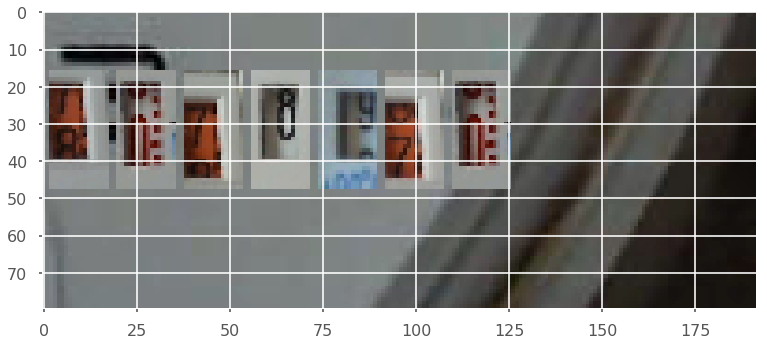

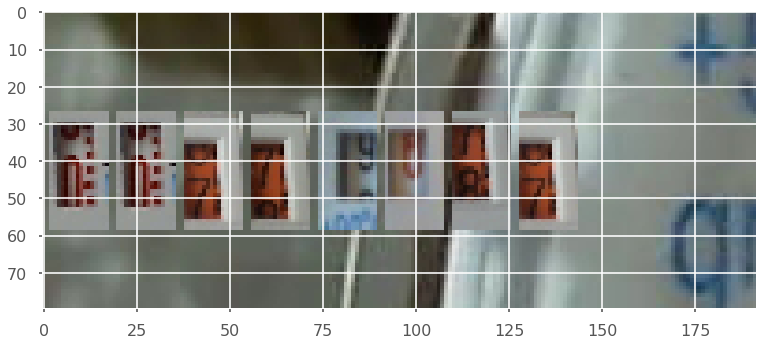

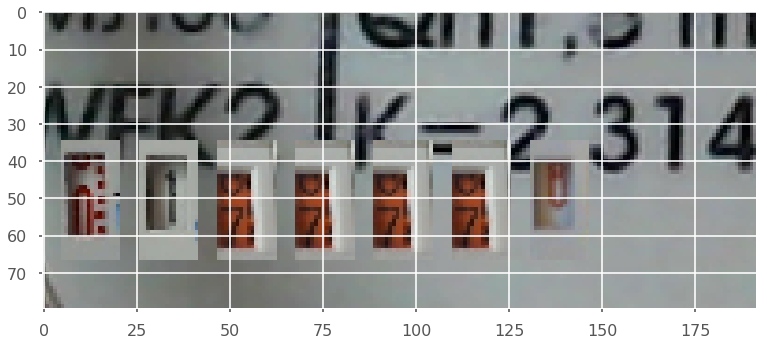

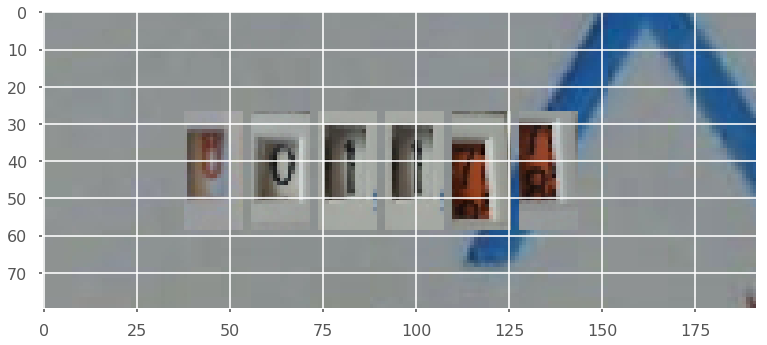

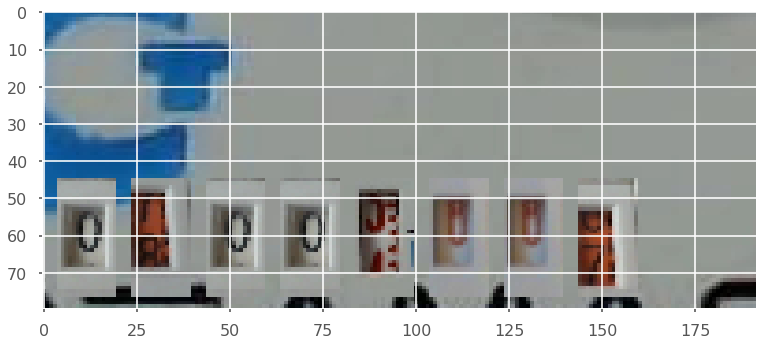

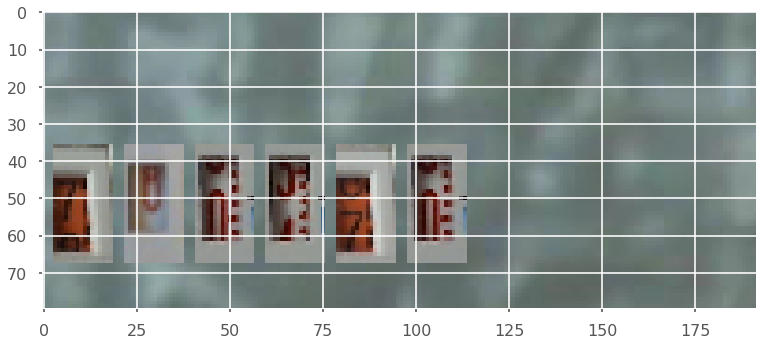

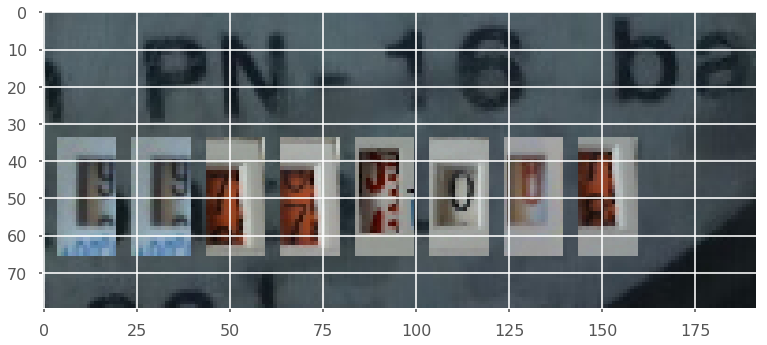

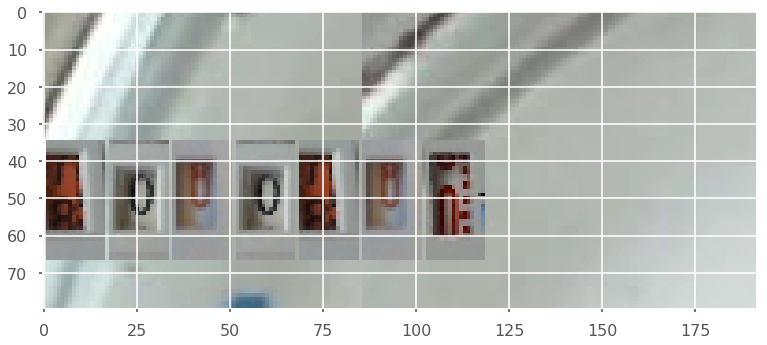

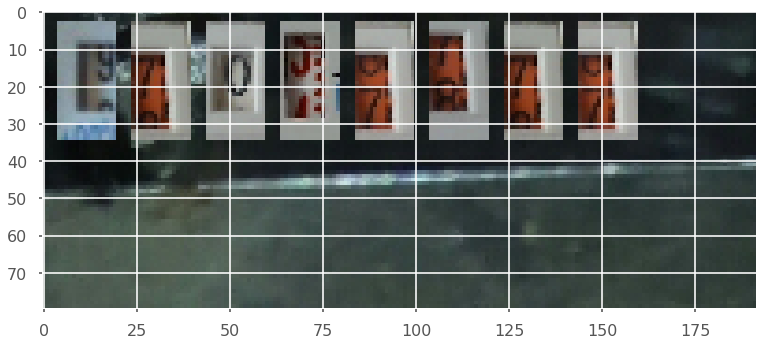

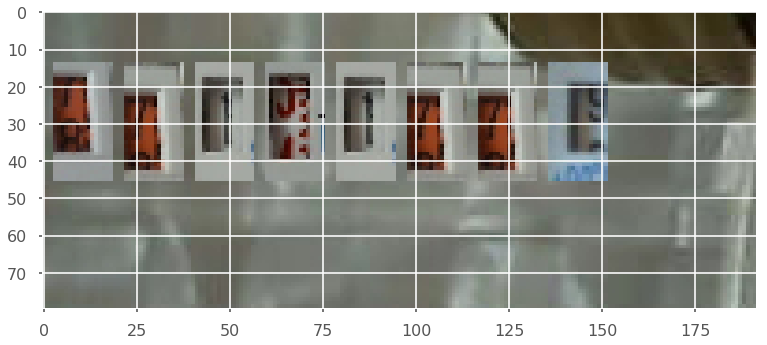

In [11]:
for i in range(10):
    plt.imshow(tr.data.new_images[i])
    plt.show()

In [ ]:
plt.imshow(tr.data.images[-10])
plt.show()

## 

In [ ]:
tr.data.confidence[-10]

In [ ]:
# inputs_config = {
#     'images': {'shape': NEW_SIZE},
#     'labels': {'classes': (10), 'transform': 'ohe', 'name': 'targets'}
# }

# config = {
#     'inputs': inputs_config,
#     'optimizer': 'Adam',
#     'loss': 'ce',
#     'input_block/inputs': 'images',
#     'head/units': [10],
#     'output': dict(ops=['labels', 'proba', 'accuracy'])
# }

In [ ]:
def smooth_l1(labels, predictions, mu=0.02, scope=None, num_digits = 8, *args, **kwargs):
    losses = 0
    for digit in range(num_digits):
        error = predictions[:, digit, :] - labels[:, digit, :]
        abs_error = tf.abs(error)
        quadratic = tf.minimum(mu, abs_error)
        losses += quadratic ** 2 / (2 * mu) + abs_error - quadratic
    return tf.reduce_mean(losses)

In [ ]:
placeholders_config = {'images': {'shape': NEW_SIZE,
                                  'name': 'reshaped_images'},
                       'labels': {'shape': (NUM_DIGITS * 10)},
                       'coordinates': {'shape': (NUM_DIGITS, 4), 'name': 'targets'},
                       'confidence': {'shape': (NUM_DIGITS, 1)}
                      }
                       
config={'inputs': placeholders_config,
        'input_block/inputs': 'images',
        'loss': smooth_l1,
        'num_digits': NUM_DIGITS,
        'output': dict(ops=['labels', 'proba', 'accuracy'])
}


saved_fetches=[V('loss'),
               B('predicted_bb'),
               V('mse'),
               V('ce_loss')]

fetches_list=['loss',
              'NearestDetection/all_predictions',
              'NearestDetection/mse',
              'NearestDetection/ce_loss']

saved_feed_dict={'images': B('images'),
                 'labels': B('labels'),
                 'coordinates': B('coordinates'),
                 'confidence': B('confidence')
                }
#         'optimizer':  {'name': 'Momentum', 'momentum': 0.5, 'learning_rate': 0.1}}

In [ ]:
t_src= '../data/images/'

fileindex = FilesIndex(path=t_src+'*.blosc', no_ext=True)

dset = Dataset(fileindex, batch_class=MeterBatch)


save_digits_ppl = (
    Pipeline()
    .load(src=t_src, fmt='blosc', components='images')
    .load(src='../data/labels/data.csv',\
          fmt='csv',\
          components=['coordinates', 'labels'],\
          index_col='file_name')
    .crop_from_bbox()
    .crop_background(new_size=NEW_SIZE)
    .dump(dst='./saved_background/', fmt='blosc', mode='w', components='background') << dset)


In [ ]:
BATCH_SIZE = 497
NUM_ITERS = 1
for i in tqn(range(NUM_ITERS)):
    tr = save_digits_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)


We will experements with models. For this create dict with:
* `key` - model
* `value` - model name

In [ ]:
models = [NearestDetection]
models_names = ['NearestDetection']
models_dict = dict(zip(models_names, models))

In [ ]:
# import dill
# import blosc
# for i in range(40):
#     with open('saved_background/' + str(i) + '.blosc', 'rb') as f:
#         data = dill.loads(blosc.decompress(f.read()))
#         plt.imshow(data['background'])
#         plt.show()

In [ ]:
def get_ppl(model, name):
    """"Create train and test pipeline using given `model` and `name`
    
    Parameters
    ----------
    model : Dataset model
        preloaded model from dataset
    
    name : str
        name of model
    
    Returns
    -------
    train_ppl : Dataset pipeline
        train pipeline

    test_ppl : Dataset pipeline
        test pipeline"""
    train_ppl = (
        (load_ppl << dset.train)
        .init_variable('model', model)
        .init_variable('loss', init_on_each_run=list)
        .init_variable('mse', init_on_each_run=list)
        .init_variable('ce_loss', init_on_each_run=list)
        .init_model('dynamic',
                    V('model'),
                    name,
                    config=config)
        .train_model(name,
                     fetches=fetches_list,
                     feed_dict=saved_feed_dict,
                     save_to=saved_fetches, 
                     mode='a')
    )

    test_ppl = (
        (load_ppl << dset.test)
        .init_variable('loss', init_on_each_run=list)
        .init_variable('mse', init_on_each_run=list)
        .init_variable('ce_loss', init_on_each_run=list)
        .init_variable('proba', init_on_each_run=list)
        .init_variable('target', init_on_each_run=list)
        .init_variable('accuracy', init_on_each_run=list)
        .import_model(name, train_ppl)
        .predict_model(name,
                       fetches=fetches_list,
                       feed_dict=saved_feed_dict,
                       save_to=saved_fetches, 
                       mode='a')
    )
    pred_ppl = (
    (load_ppl << dset.test)
    .init_variable('loss', init_on_each_run=list)
    .import_model(name, train_ppl)
    .predict_model(name,
                   fetches=fetches_list,
                   feed_dict=saved_feed_dict,
                   save_to=saved_fetches, 
                   mode='a')
    )
    return train_ppl, test_ppl

train pipelines with different models and save it after training

In [ ]:
models_dict.items()

In [ ]:
NUM_ITERS = 2000

In [ ]:
for filename in black_list:
    os.remove("saved_images/" + str(filename) + ".blosc")

In [ ]:
global_acc = []
for name, model in models_dict.items():
    print(name)
    train_ppl, test_ppl = get_ppl(model, name)
#     for i in tqn(range(NUM_ITERS)):
#         tr = train_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)
#         te = test_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)

In [ ]:
NUM_ITERS = 5000
BATCH_SIZE = 25

In [ ]:
for i in tqn(range(NUM_ITERS)):
    tr = train_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)
    te = test_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)

In [ ]:
print('ok')

In [ ]:
NUM_ITERS = 4000
for i in tqn(range(NUM_ITERS)):
    tr = train_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)
#     te = test_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)

In [ ]:
train_ppl.save_model(name, path='Sailor')

In [ ]:
np.mean((np.array(test_ppl.get_variable('loss')) - np.array(test_ppl.get_variable('ce_loss')))[-500:])

In [ ]:
plt.plot((np.array(test_ppl.get_variable('loss')) - np.array(test_ppl.get_variable('ce_loss')))[-500:], label='ResNet' + 'loss')


In [ ]:
plt.plot(test_ppl.get_variable('mse')[-500:], label='ResNet' + 'loss')
plt.legend(fontsize=14)
plt.show()


In [ ]:
plt.plot(train_ppl.get_variable('loss'), label='ResNet' + 'loss')
plt.legend(fontsize=14)
plt.show()


In [ ]:
plt.plot(train_ppl.get_variable('ce_loss'), label='ResNet' + 'loss')
plt.legend(fontsize=14)
plt.show()


In [ ]:
plt.plot(train_ppl.get_variable('mse')[-500:], label='ResNet' + 'loss')
plt.legend(fontsize=14)
plt.show()

In [ ]:
np.mean(np.array((test_ppl.get_variable('mse')[-20:])))

In [ ]:
np.mean(np.array((train_ppl.get_variable('loss')[-20:])))

In [ ]:
np.mean(np.array((train_ppl.get_variable('mse')[-100:])))

In [ ]:
train_ppl.save_model(name, path='NearestDetection-2')

In [ ]:
# class_placeholders_config = {'images': {'shape': NEW_SIZE,
#                                   'name': 'reshaped_images'},
#                        'labels': {
#                                   'shape': (10),
#                                   'name': 'targets'},
# #                        'coordinates': {'shape': (NUM_DIGITS, 4)},
#                       }
                       
# classification_config={'inputs': class_placeholders_config,
#         'input_block/inputs': 'images',
# #         'loss': None,
#         'num_digits': NUM_DIGITS,
#         'output': dict(ops=['labels', 'proba', 'accuracy'])
# }

In [ ]:
config['load'] = {'path':'./NearestDetection/'}
# config['load']['checkpoint'] = None
# config['build'] = False
model = NearestDetection(config=config)

In [ ]:
model.body

In [ ]:
classification_config

In [ ]:
class_placeholders_config = {'images': {'shape': (HEIGHT, WIDTH, 3), 'name': 'reshaped_images'},
                             'labels': {'shape': (10), 'name': 'targets'},
#                        'coordinates': {'shape': (NUM_DIGITS, 4)},
                      }
                       
classification_config={'inputs': class_placeholders_config,
        'input_block/inputs': 'images',
        'loss': 'ce',
        'num_digits': NUM_DIGITS,
        'output': dict(ops=['labels', 'proba', 'accuracy'])
}
classification_config['load'] = {'path':'./ClassificationModel/'}
classification_config['load']['graph'] = None

classification_config['build'] = False

In [ ]:
classification_model = ClassificationModel(session=None, config=classification_config)

# Load model

In [ ]:
from meters.dataset.dataset.models.tf import TFModel

In [ ]:
test_ppl = (
    (load_ppl << dset.test)
    .init_variable('loss', init_on_each_run=list)
    .init_variable('mse', init_on_each_run=list)
    .init_variable('accuracy', init_on_each_run=list)
    .init_variable('ce_loss', init_on_each_run=list)
#     .import_model('NearestDetection', train_ppl)
    .init_model('dynamic', TFModel, 'NearestDetection', config={'load': {'path': './Sailor/'}, 'build': False})
    .predict_model('NearestDetection',
                   fetches=fetches_list,
                   feed_dict=saved_feed_dict,
                   save_to=saved_fetches, 
                   mode='w')
    .crop_predictions(n_workers=1)
    .split_cropped()
    .compute_confidence_accuracy()

    #     .import_model('ClassificationModel', classification_model)
#     .predict_model('ClassificationModel',
#                      fetches=['loss', 'accuracy'],
#                      feed_dict={'images': B('images'),
#                                 'labels': B('labels')},
#                      save_to=[V('loss'), V('accuracy')], 
#                      mode='a')
    )

In [ ]:
NUM_ITERS = 5

In [ ]:
for i in tqn(range(NUM_ITERS)):
    test_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)

### test_ppl.get_variable('loss')


In [ ]:
test_ppl = (
    (load_ppl << dset.test)
    .init_variable('loss', init_on_each_run=list)
    .init_variable('mse', init_on_each_run=list)
    .init_variable('accuracy', init_on_each_run=list)
    .init_variable('ce_loss', init_on_each_run=list)
#     .import_model('NearestDetection', train_ppl)
    .init_model('dynamic', TFModel, 'NearestDetection', config={'load': {'path': './Sailor/'}, 'build': False})
    .predict_model('NearestDetection',
                   fetches=fetches_list,
                   feed_dict=saved_feed_dict,
                   save_to=saved_fetches, 
                   mode='w')
    .crop_predictions(n_workers=1)
    .split_cropped()
    .compute_confidence_accuracy()
    
    #     .import_model('ClassificationModel', classification_model)
#     .predict_model('ClassificationModel',
#                      fetches=['loss', 'accuracy'],
#                      feed_dict={'images': B('images'),
#                                 'labels': B('labels')},
#                      save_to=[V('loss'), V('accuracy')], 
#                      mode='a')
    )

In [ ]:
test_ppl.get_variable('ce_loss')


In [ ]:
btch = test_ppl.next_batch(batch_size=8, n_epochs=None, suffle=True, drop_last=True)

In [ ]:
import numpy as np

In [ ]:
np.random.randint(0, 10)

In [ ]:
btch.data.images.shape

In [ ]:
btch.data.cropped_images.shape

In [ ]:
def unnorm(data):
    data = data.reshape((-1, 4))
    data[:, 0] *= NEW_SIZE[0]
    data[:, 2] *= NEW_SIZE[0]
    data[:, 1] *= NEW_SIZE[1]
    data[:, 3] *= NEW_SIZE[1]
    return data

def plot_results(btch, at_once=True):
    index = np.random.randint(btch.data.images.shape[0])
    img = btch.data.images[index]
    predictions = btch.data.predicted_bb[index].reshape((-1, 5))
    coords = unnorm(predictions[:, :4])
    real = unnorm(btch.data.coordinates[index])
    pred_conf = predictions[:, 4]
    if at_once:
        fig,ax = plt.subplots(1)
    for i in range(8):
        if not at_once:
            print('pred confidence: ', pred_conf[i], 'real conf: ', btch.data.confidence[index, i, 0])
            fig,ax = plt.subplots(1)
            ax.imshow(img)
            plt.show()
        y, x, height, width = coords[i]
        pred_rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(pred_rect)

        y, x, height, width = real[i]
        true_rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(true_rect)
        

    if at_once:
        ax.imshow(img)
        plt.show()
        print('pred confidence: ', pred_conf, 'real conf: ', btch.data.confidence[index, :, 0])


    

In [ ]:
from scipy.special import expit


In [ ]:
btch = test_ppl.next_batch(batch_size=8, n_epochs=None, suffle=True, drop_last=True)
plot_results(btch, at_once=True)

In [ ]:
btch = test_ppl.next_batch(batch_size=8, n_epochs=None, suffle=True, drop_last=True)
plot_results(btch)

In [ ]:
load_ppl = (
    Pipeline()
    .load(src=src, fmt='blosc', components='images')
    .load(src='labels/data.csv',\
          fmt='csv',\
          components=['coordinates', 'labels'],\
          index_col='file_name')
    .crop_from_bbox()
    .crop_background(new_size=NEW_SIZE)
    .split_labels()
    .split_to_digits(n_digits=8)
    .resize(shape=(HEIGHT, WIDTH))
    .one_hot()
    .generate_data(n_digits=NUM_DIGITS, normalize=True, prob=0.5)
)

In [ ]:
pred_ppl = (
    (load_ppl << dset.test)
    .init_variable('loss', init_on_each_run=list)
    .import_model(name, train_ppl)
    .predict_model(name,
                   fetches=fetches_list,
                   feed_dict=saved_feed_dict,
                   save_to=saved_fetches, 
                   mode='a')
    )
    .init_model('dynamic', V('model'),
    name,
    config=config)
    .train_model(name,
     fetches=fetches_list,
     feed_dict=saved_feed_dict,
     save_to=saved_fetches, 
     mode='a')
    




All models was trained and reach almost the same accuracy ~ 0.9-1. Let's load one of them to plot the results.

In [ ]:
config['load'] = {'path':'./DenseNet121/'}

In [ ]:
%%time
model = DenseNet121(config=config)

Create pipeline to predict numbers on meters

In [ ]:
predict_ppl = (
    (load_ppl << dset.test)
    .init_variable('prediction', init_on_each_run=list)
    .init_variable('proba', init_on_each_run=list)
    .init_variable('accuracy', init_on_each_run=list)
    .import_model('DenseNet121', model)
    .predict_model('DenseNet121',
                   fetches=['output_labels',
                            'output_proba',
                            'output_accuracy'],
                   make_data=make_separate_digits,
                   save_to=[V('prediction'),
                            V('proba'),
                            V('accuracy')],
                   mode='a')
)

Plot prediction numbers

In [ ]:
batch_test = predict_ppl.next_batch(1, n_epochs=None, shuffle=True)

predict = predict_ppl.get_variable('prediction')[-1]
labels = batch_test.labels[-1]
sepcrop = batch_test.sepcrop[-1]
plt.title('Input image', fontsize=20)
plt.imshow(batch_test.images[-1])
plt.grid()
plt.show()

plt.title('Bounding box', fontsize=20)
plt.imshow(batch_test.cropped[-1])
plt.grid()

_, axis = plt.subplots(1, 8, figsize=(20, 10))
axis = axis.reshape(-1)
for i in range(8):
    axis[i].imshow(sepcrop[i])
    axis[i].set_title('Predict: {} \nAnswer: {}'.format(predict[i], labels[i]), fontsize=20)
    axis[i].grid()
    axis[i].axis('off')
plt.show()